In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

C:\Users\Irfan\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow version:", keras.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.10.0
NumPy version: 1.26.0


In [3]:
gRNA_LENGTH = 28
input_length = 33

In [4]:
dct_ohc_seq = {'A': [1, 0, 0, 0],
               'C': [0, 1, 0, 0],
               'G': [0, 0, 1, 0],
               'T': [0, 0, 0, 1],
               'N': [0, 0, 0, 0]}

def seq_one_hot_code(seq):
    seq = seq.upper()
    lst_seq = list(seq)
    return [dct_ohc_seq[i] for i in lst_seq]

In [5]:
file = 'BS6204_input.10WINDOW.csv'
WINDOW_LENGTH_ORIGINAL=10
LENGTH_TO_TEST=3
INPUT_LENGTH=LENGTH_TO_TEST + gRNA_LENGTH + LENGTH_TO_TEST
ACTUAL_LENGTH = WINDOW_LENGTH_ORIGINAL + gRNA_LENGTH + WINDOW_LENGTH_ORIGINAL

class inputObject:
    
    def __init__(self, col):
        self.seq_id = col[0]
        assert len(col[1]) == ACTUAL_LENGTH
        self.seq = col[1][WINDOW_LENGTH_ORIGINAL-LENGTH_TO_TEST:WINDOW_LENGTH_ORIGINAL+gRNA_LENGTH+LENGTH_TO_TEST]
        #self.quartile = int(col[2].replace('Q',''))
        #self.guideScore = float(col[3])
        self.quartile = None
        self.guideScore = None

seq_dict = {}
with open(file, 'r') as f:
    next(f)
    for line in f:
        col = line.strip('\n').split(',')
        seq_id = col[0]
        seq_dict[seq_id] = inputObject(col)

# Update Using Mean-Normalized Score2
file2 = "MeanAdjustedScores.csv"
with open(file2, 'r') as f:
    next(f)
    for line in f:
        col = [i.replace('"','').replace('"','') for i in line.strip('\n').split(',')]
        seq_id = col[0] 
        seq_dict[seq_id].quartile = int(col[11].replace('Q',''))
        seq_dict[seq_id].guideScore = float(col[10])

In [6]:
seq   = []
score = []
quart = []

for k,v in seq_dict.items():
    seq.append(v.seq)
    score.append(v.guideScore)
    quart.append(v.quartile-1)
    
target_data = np.array(score)
quart_data  = np.array(quart)
    
nt_dict = {'A':1, 'C':2, 'G':3, 'T':4, 'N':0}    

# X_train_seq = [seq_one_hot_code(s) for s in seq]
X_train_seq = [[nt_dict[s] for s in s1] for s1 in seq]
X_train_arr_seq = np.array(X_train_seq)

quart = [0 if i<2 else 1 for i in quart]
quart_data = np.array(quart)
num_classes = 2
one_hot_labels = to_categorical(quart_data, num_classes)

In [7]:
print(quart.count(0), quart.count(1))

225 225


In [8]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, TimeDistributed, Flatten, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers import concatenate
from keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, Reshape

# Sequential model for sequence input
seq_model = Sequential()
seq_model.add(Reshape((INPUT_LENGTH, 1), input_shape=(INPUT_LENGTH,)))  # Reshape input

# Add a Bidirectional LSTM layer
#seq_model.add(Bidirectional(LSTM(units=INPUT_LENGTH, return_sequences=True, activation='relu'))) # You can adjust the number of units as needed
#seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(64, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Dense(32, activation='relu'))
seq_model.add(Dropout(0.3))
seq_model.add(Flatten())

NN_output  = Dense(2, activation='softmax')(seq_model.output)

# Create the final model
NN_model = Model(inputs=[seq_model.input], outputs=NN_output)


In [9]:
NN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_input (InputLayer)  [(None, 34)]              0         
                                                                 
 reshape (Reshape)           (None, 34, 1)             0         
                                                                 
 dense (Dense)               (None, 34, 64)            128       
                                                                 
 dropout (Dropout)           (None, 34, 64)            0         
                                                                 
 dense_1 (Dense)             (None, 34, 64)            4160      
                                                                 
 dropout_1 (Dropout)         (None, 34, 64)            0         
                                                                 
 dense_2 (Dense)             (None, 34, 32)            2080  

Code for Model Training

In [10]:
from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

In [11]:
def custom_true_positive_metric(y_true, y_pred):
    # Calculate True Positives (TP)
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    
    # Return True Positives as the custom metric
    return true_positives

def custom_loss(y_true, y_pred):
    # Weight for False Negatives (increase this value to prioritize TP)
    weight_fn = 10  # You can adjust this value as needed

    # Ensure y_true and y_pred are compatible for binary classification
    y_true = tf.cast(y_true, tf.float32)

    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Calculate the number of False Negatives (FN)
    fn = tf.reduce_sum(tf.maximum(y_true - y_pred, 0))

    # Modify the loss by applying the weight to FN
    custom_loss = bce + weight_fn * fn

    return custom_loss

In [12]:
# let's define more parameters
# yinning.huang@gmail.com
batch_size = 128
num_epochs = 120

from keras.optimizers import SGD, Adam  # or any other optimizer you are using

# Define your optimizer with a custom learning rate
custom_lr = 0.0025  # Change this value to the desired learning rate 
custom_optimizer = Adam(learning_rate=custom_lr)


NN_model.compile(loss      = custom_loss, # binary_crossentropy,
                 optimizer = custom_optimizer,
                 metrics   = [custom_true_positive_metric, "accuracy"]) # ["accuracy"]

In [13]:
#X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH, 4, 1)) 
X_train_seq_CNN = np.reshape(X_train_arr_seq, (len(X_train_arr_seq), INPUT_LENGTH)) 

In [14]:
history = NN_model.fit([X_train_seq_CNN], one_hot_labels, epochs=num_epochs, batch_size=batch_size, validation_split = 0.2)

Epoch 1/120
3/3 [==============================] - 1s 188ms/step - loss: 605.3287 - custom_true_positive_metric: 62.0000 - accuracy: 0.5167 - val_loss: 464.5038 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 2/120
3/3 [==============================] - 0s 21ms/step - loss: 595.0369 - custom_true_positive_metric: 61.3333 - accuracy: 0.5111 - val_loss: 470.1065 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 3/120
3/3 [==============================] - 0s 20ms/step - loss: 588.7543 - custom_true_positive_metric: 62.0000 - accuracy: 0.5167 - val_loss: 482.3322 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 4/120
3/3 [==============================] - 0s 22ms/step - loss: 587.6897 - custom_true_positive_metric: 61.6667 - accuracy: 0.5139 - val_loss: 489.9437 - val_custom_true_positive_metric: 40.0000 - val_accuracy: 0.4444
Epoch 5/120
3/3 [==============================] - 0s 25ms/step - loss: 587.2805 - custom_true_

3/3 [==============================] - 0s 21ms/step - loss: 450.3175 - custom_true_positive_metric: 75.3333 - accuracy: 0.6278 - val_loss: 449.3107 - val_custom_true_positive_metric: 45.0000 - val_accuracy: 0.5000
Epoch 74/120
3/3 [==============================] - 0s 20ms/step - loss: 456.7040 - custom_true_positive_metric: 75.6667 - accuracy: 0.6306 - val_loss: 453.5485 - val_custom_true_positive_metric: 44.0000 - val_accuracy: 0.4889
Epoch 75/120
3/3 [==============================] - 0s 21ms/step - loss: 426.0293 - custom_true_positive_metric: 79.0000 - accuracy: 0.6583 - val_loss: 466.8677 - val_custom_true_positive_metric: 43.0000 - val_accuracy: 0.4778
Epoch 76/120
3/3 [==============================] - 0s 21ms/step - loss: 429.6172 - custom_true_positive_metric: 77.6667 - accuracy: 0.6472 - val_loss: 490.3393 - val_custom_true_positive_metric: 41.0000 - val_accuracy: 0.4556
Epoch 77/120
3/3 [==============================] - 0s 21ms/step - loss: 407.4456 - custom_true_positive_

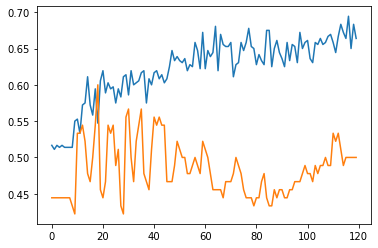

In [15]:
# plot accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

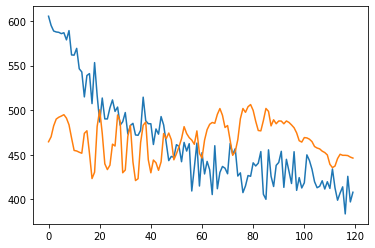

In [16]:
# plot losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [17]:
predicted_values_for_X_train = NN_model.predict([X_train_seq_CNN])
predicted_values_for_X_train

15/15 [==============================] - 0s 2ms/step


array([[1.00000000e+00, 1.56733138e-09],
       [9.99999404e-01, 6.06486822e-07],
       [9.98390198e-01, 1.60981086e-03],
       [9.94844079e-01, 5.15585486e-03],
       [6.55215289e-14, 1.00000000e+00],
       [7.87772834e-01, 2.12227106e-01],
       [1.99621014e-10, 1.00000000e+00],
       [9.99967575e-01, 3.23680761e-05],
       [9.99984145e-01, 1.58914845e-05],
       [1.00000000e+00, 6.17901064e-10],
       [1.00000000e+00, 2.04000900e-10],
       [9.99927044e-01, 7.29472158e-05],
       [3.40770593e-16, 1.00000000e+00],
       [4.67615515e-01, 5.32384455e-01],
       [5.29185983e-12, 1.00000000e+00],
       [1.00000000e+00, 1.80092847e-08],
       [9.99999881e-01, 1.26001325e-07],
       [6.68607056e-01, 3.31393003e-01],
       [9.99965549e-01, 3.44772961e-05],
       [9.99977231e-01, 2.27780038e-05],
       [2.25399035e-07, 9.99999762e-01],
       [9.99770820e-01, 2.29170415e-04],
       [1.00000000e+00, 3.40630403e-15],
       [4.19701487e-01, 5.80298543e-01],
       [3.208517

In [18]:
predicted_labels = np.argmax(predicted_values_for_X_train, axis=1)
poor_count = 0
for c, (i,j) in enumerate(zip(predicted_labels, quart_data)):
    poor = 'Poor' if i == 1 and j == 0 else 'Okay'
    if poor == 'Poor':
        poor_count += 1
    print (c, "Pred", i, "True", j, i==j, poor)

0 Pred 0 True 0 True Okay
1 Pred 0 True 0 True Okay
2 Pred 0 True 0 True Okay
3 Pred 0 True 0 True Okay
4 Pred 1 True 0 False Poor
5 Pred 0 True 0 True Okay
6 Pred 1 True 0 False Poor
7 Pred 0 True 0 True Okay
8 Pred 0 True 0 True Okay
9 Pred 0 True 1 False Okay
10 Pred 0 True 0 True Okay
11 Pred 0 True 0 True Okay
12 Pred 1 True 0 False Poor
13 Pred 1 True 0 False Poor
14 Pred 1 True 1 True Okay
15 Pred 0 True 1 False Okay
16 Pred 0 True 0 True Okay
17 Pred 0 True 1 False Okay
18 Pred 0 True 0 True Okay
19 Pred 0 True 1 False Okay
20 Pred 1 True 1 True Okay
21 Pred 0 True 0 True Okay
22 Pred 0 True 0 True Okay
23 Pred 1 True 1 True Okay
24 Pred 1 True 0 False Poor
25 Pred 0 True 1 False Okay
26 Pred 0 True 1 False Okay
27 Pred 1 True 1 True Okay
28 Pred 0 True 1 False Okay
29 Pred 0 True 0 True Okay
30 Pred 0 True 1 False Okay
31 Pred 1 True 1 True Okay
32 Pred 1 True 1 True Okay
33 Pred 0 True 0 True Okay
34 Pred 1 True 1 True Okay
35 Pred 0 True 0 True Okay
36 Pred 1 True 1 True Oka

386 Pred 1 True 0 False Poor
387 Pred 0 True 0 True Okay
388 Pred 0 True 0 True Okay
389 Pred 1 True 0 False Poor
390 Pred 0 True 1 False Okay
391 Pred 1 True 1 True Okay
392 Pred 0 True 1 False Okay
393 Pred 0 True 1 False Okay
394 Pred 1 True 1 True Okay
395 Pred 1 True 1 True Okay
396 Pred 0 True 1 False Okay
397 Pred 1 True 0 False Poor
398 Pred 0 True 0 True Okay
399 Pred 1 True 0 False Poor
400 Pred 1 True 1 True Okay
401 Pred 0 True 0 True Okay
402 Pred 0 True 0 True Okay
403 Pred 1 True 0 False Poor
404 Pred 0 True 0 True Okay
405 Pred 1 True 0 False Poor
406 Pred 0 True 1 False Okay
407 Pred 1 True 1 True Okay
408 Pred 0 True 1 False Okay
409 Pred 0 True 0 True Okay
410 Pred 0 True 1 False Okay
411 Pred 1 True 1 True Okay
412 Pred 0 True 0 True Okay
413 Pred 1 True 0 False Poor
414 Pred 1 True 0 False Poor
415 Pred 1 True 1 True Okay
416 Pred 1 True 0 False Poor
417 Pred 1 True 0 False Poor
418 Pred 1 True 0 False Poor
419 Pred 0 True 1 False Okay
420 Pred 1 True 0 False Poor


In [19]:
print (poor_count, len(quart_data))

59 450


In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(quart_data,predicted_labels)
cm

array([[166,  59],
       [ 87, 138]], dtype=int64)